## google drive'a bağlan

In [119]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## indirme, bindirme scriptleri

In [1]:
# download files 
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()


def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)


def download(path):
  from google.colab import files
  files.download(path)

In [2]:
!ls

darknet_deneme_tahtası.ipynb


## python kodlarını başladığı yer

In [122]:
## config dosyalarını colab makinesine kopyala
%cd /content/gdrive/MyDrive/
!cp -r  yolov3.cfg  yolov3.weights coco.names /content



/content/gdrive/MyDrive


## ana dizine gel ve gerekli libleri indir

In [123]:
%cd /content/yolo
!ls

/content/yolo
coco.names  yolov3.cfg	yolov3.weights


In [124]:
%cd /content
! mkdir yolo
! mv yolov3.cfg yolov3.weights coco.names yolo/

# gereksinimler
# !pip -V   -> pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)

!pip install numpy imutils opencv-python

/content
mkdir: cannot create directory ‘yolo’: File exists


In [5]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from skimage import io

In [9]:
# load the COCO class labels our YOLO model was trained on
objNames = ["dog", "truck", "giraffe", "banana"]
labelsPath = os.path.sep.join(["../yolo", "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(["../yolo", "yolov3.weights"])
configPath = os.path.sep.join(["../yolo", "yolov3.cfg"])


In [10]:

# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

"""
# to gpu
# opencvyi gpu kullanarak compile edebiliyoruz cuda kullanıyor videolar üzerinden işlem yaparken 
# fakat onun için cuda'nın vs hep local makinada kurulu olması lazım ben anaconda kullandığım için pek mümkün olmuyor
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
"""

ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]



giraffe bulundu.


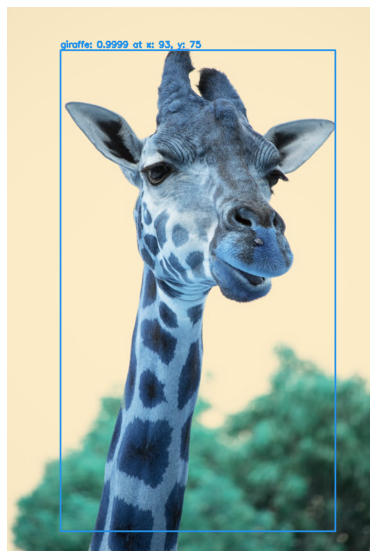

In [15]:
url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg"
url2 = "https://images.unsplash.com/photo-1469259943454-aa100abba749?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=634&q=80"
url3 = "https://images.unsplash.com/photo-1575412626264-ea664af9292d?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1350&q=80"
url4 = "https://images.unsplash.com/photo-1481349518771-20055b2a7b24?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1109&q=80"
url5 = "https://images.unsplash.com/photo-1547721064-da6cfb341d50?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=634&q=80"

frame = io.imread(url5)


(W, H) = (None, None)

# if the frame dimensions are empty, grab them
if W is None or H is None:
    (H, W) = frame.shape[:2]

# construct a blob from the input frame and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes
# and associated probabilities
blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
    swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

# initialize our lists of detected bounding boxes, confidences,
# and class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability)
        # of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > 0.5:
            # scale the bounding box coordinates back relative to
            # the size of the image, keeping in mind that YOLO
            # actually returns the center (x, y)-coordinates of
            # the bounding box followed by the boxes' width and
            # height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top
            # and and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates,
            # confidences, and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

# apply non-maxima suppression to suppress weak, overlapping
# bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,
    0.3)

# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # draw a bounding box rectangle and label on the frame
        color = [int(c) for c in COLORS[classIDs[i]]]
        for obj in objNames:
            if LABELS[classIDs[i]] == obj:
                print(f"{obj} bulundu.")
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f} at x: {}, y: {}".format(LABELS[classIDs[i]],
                    confidences[i], x, y)
                cv2.putText(frame, text, (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
           
cv2.imwrite("resim.png", frame)
imShow('resim.png')